In [2]:
import numpy as np
import torch
from pkg_resources import packaging

In [3]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [16]:
model, preprocess = clip.load("ViT-L/14@336px")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|███████████████████████████████████████| 891M/891M [02:35<00:00, 5.99MiB/s]


In [8]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f0216e33380>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [9]:
import json
import requests

In [10]:
labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
labels = json.loads(requests.get(labels_url).text)
imagenet_labels = []
imagenet_labels = [labels[str(k)][1] for k in range(len(labels))]

In [11]:
text_descriptions = [f"This is a photo of a {label}" for label in imagenet_labels]
text_tokens = clip.tokenize(text_descriptions).to(device)

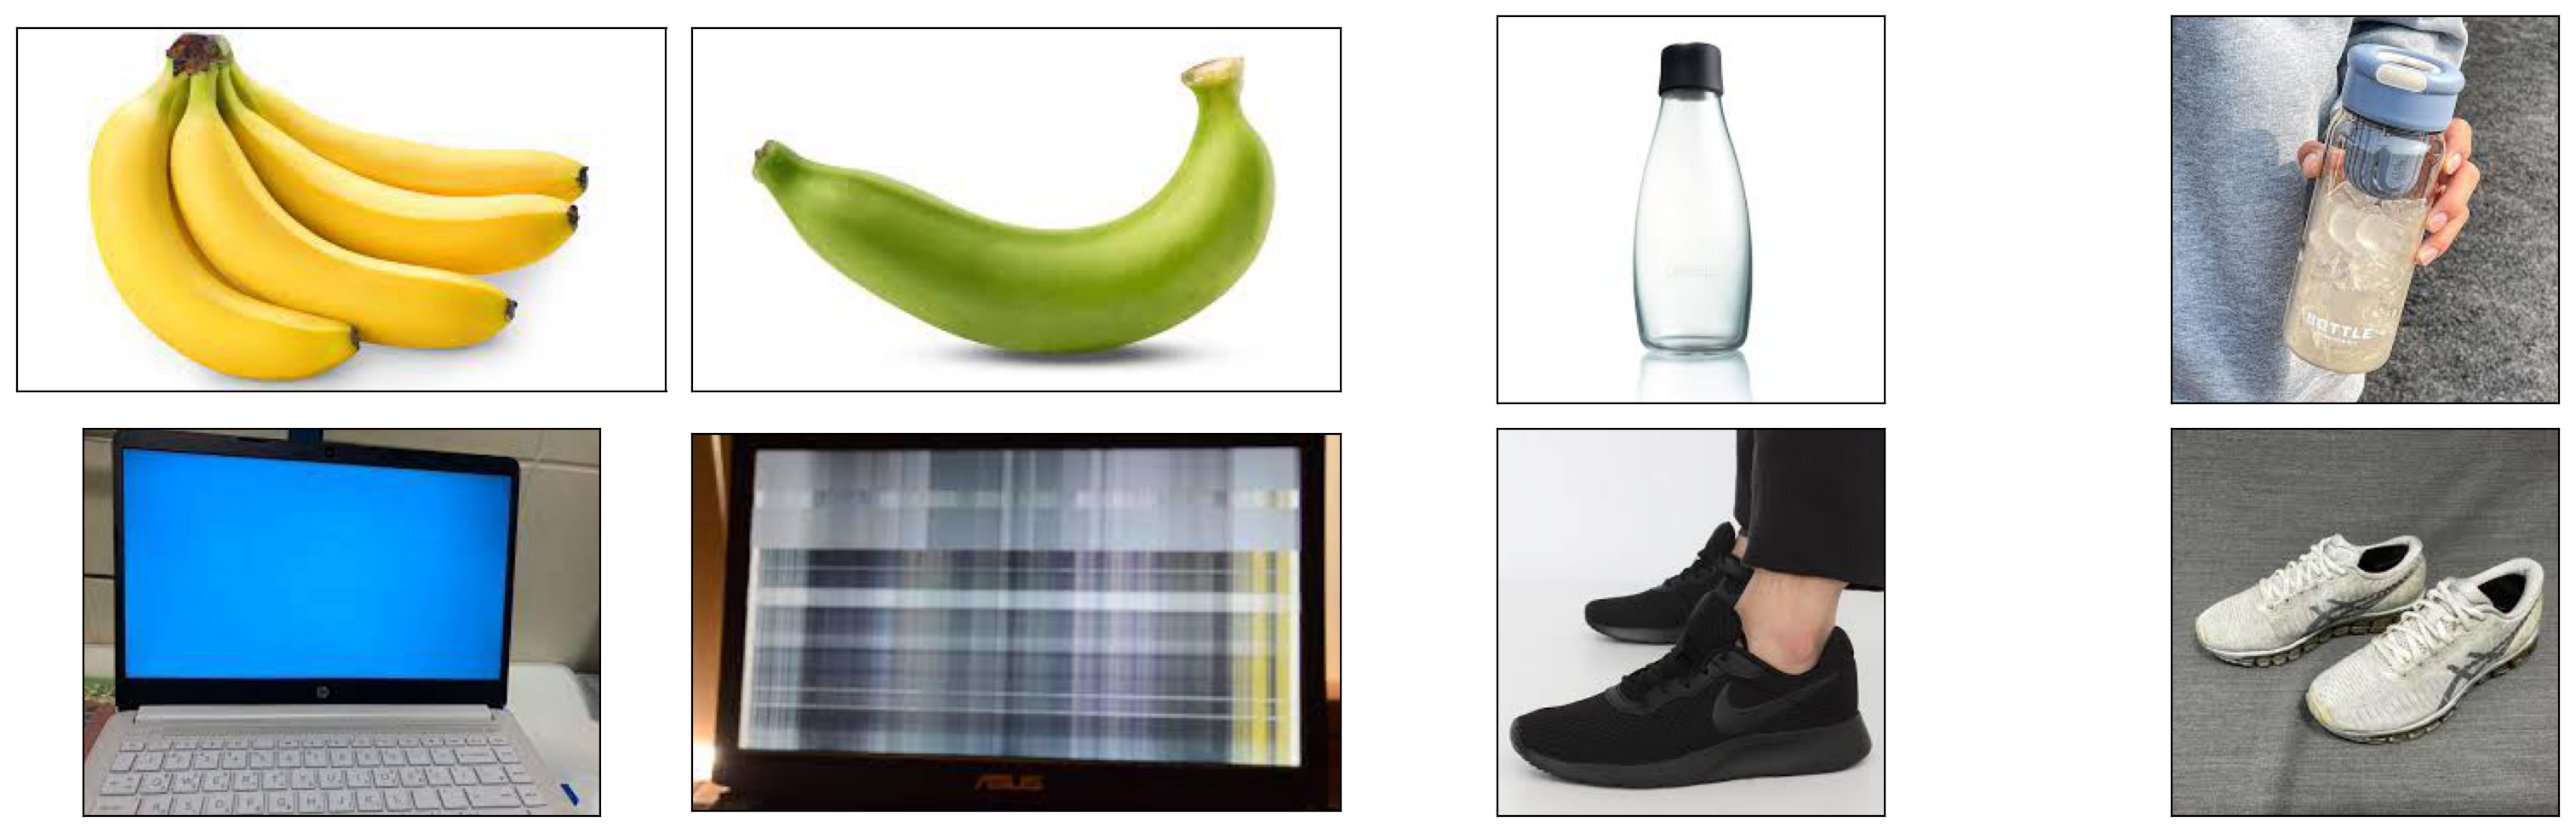

In [12]:
original_images = []
images = []
plt.figure(figsize=(16, 5))

image1 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/banana/banana1.jpg').convert("RGB")
image2 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/banana/banana2.jpg').convert("RGB")
image3 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/bottle/bottle1.jpg').convert("RGB")
image4 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/bottle/bottle2.jpg').convert("RGB")
image5 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/laptop/laptop1.jpg').convert("RGB")
image6 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/laptop/laptop2.jpg').convert("RGB")
image7 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/running_shoe/running_shoe1.jpg').convert("RGB")
image8 = Image.open('/home/doomchit/Desktop/Personal/data/manual/training/running_shoe/running_shoe2.jpg').convert("RGB")

original_images = [image1, image2, image3, image4, image5, image6, image7, image8]  

for image in original_images:
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))

plt.tight_layout()


In [13]:
image_input = torch.tensor(np.stack(images)).to(device)

In [14]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(7, dim=-1)

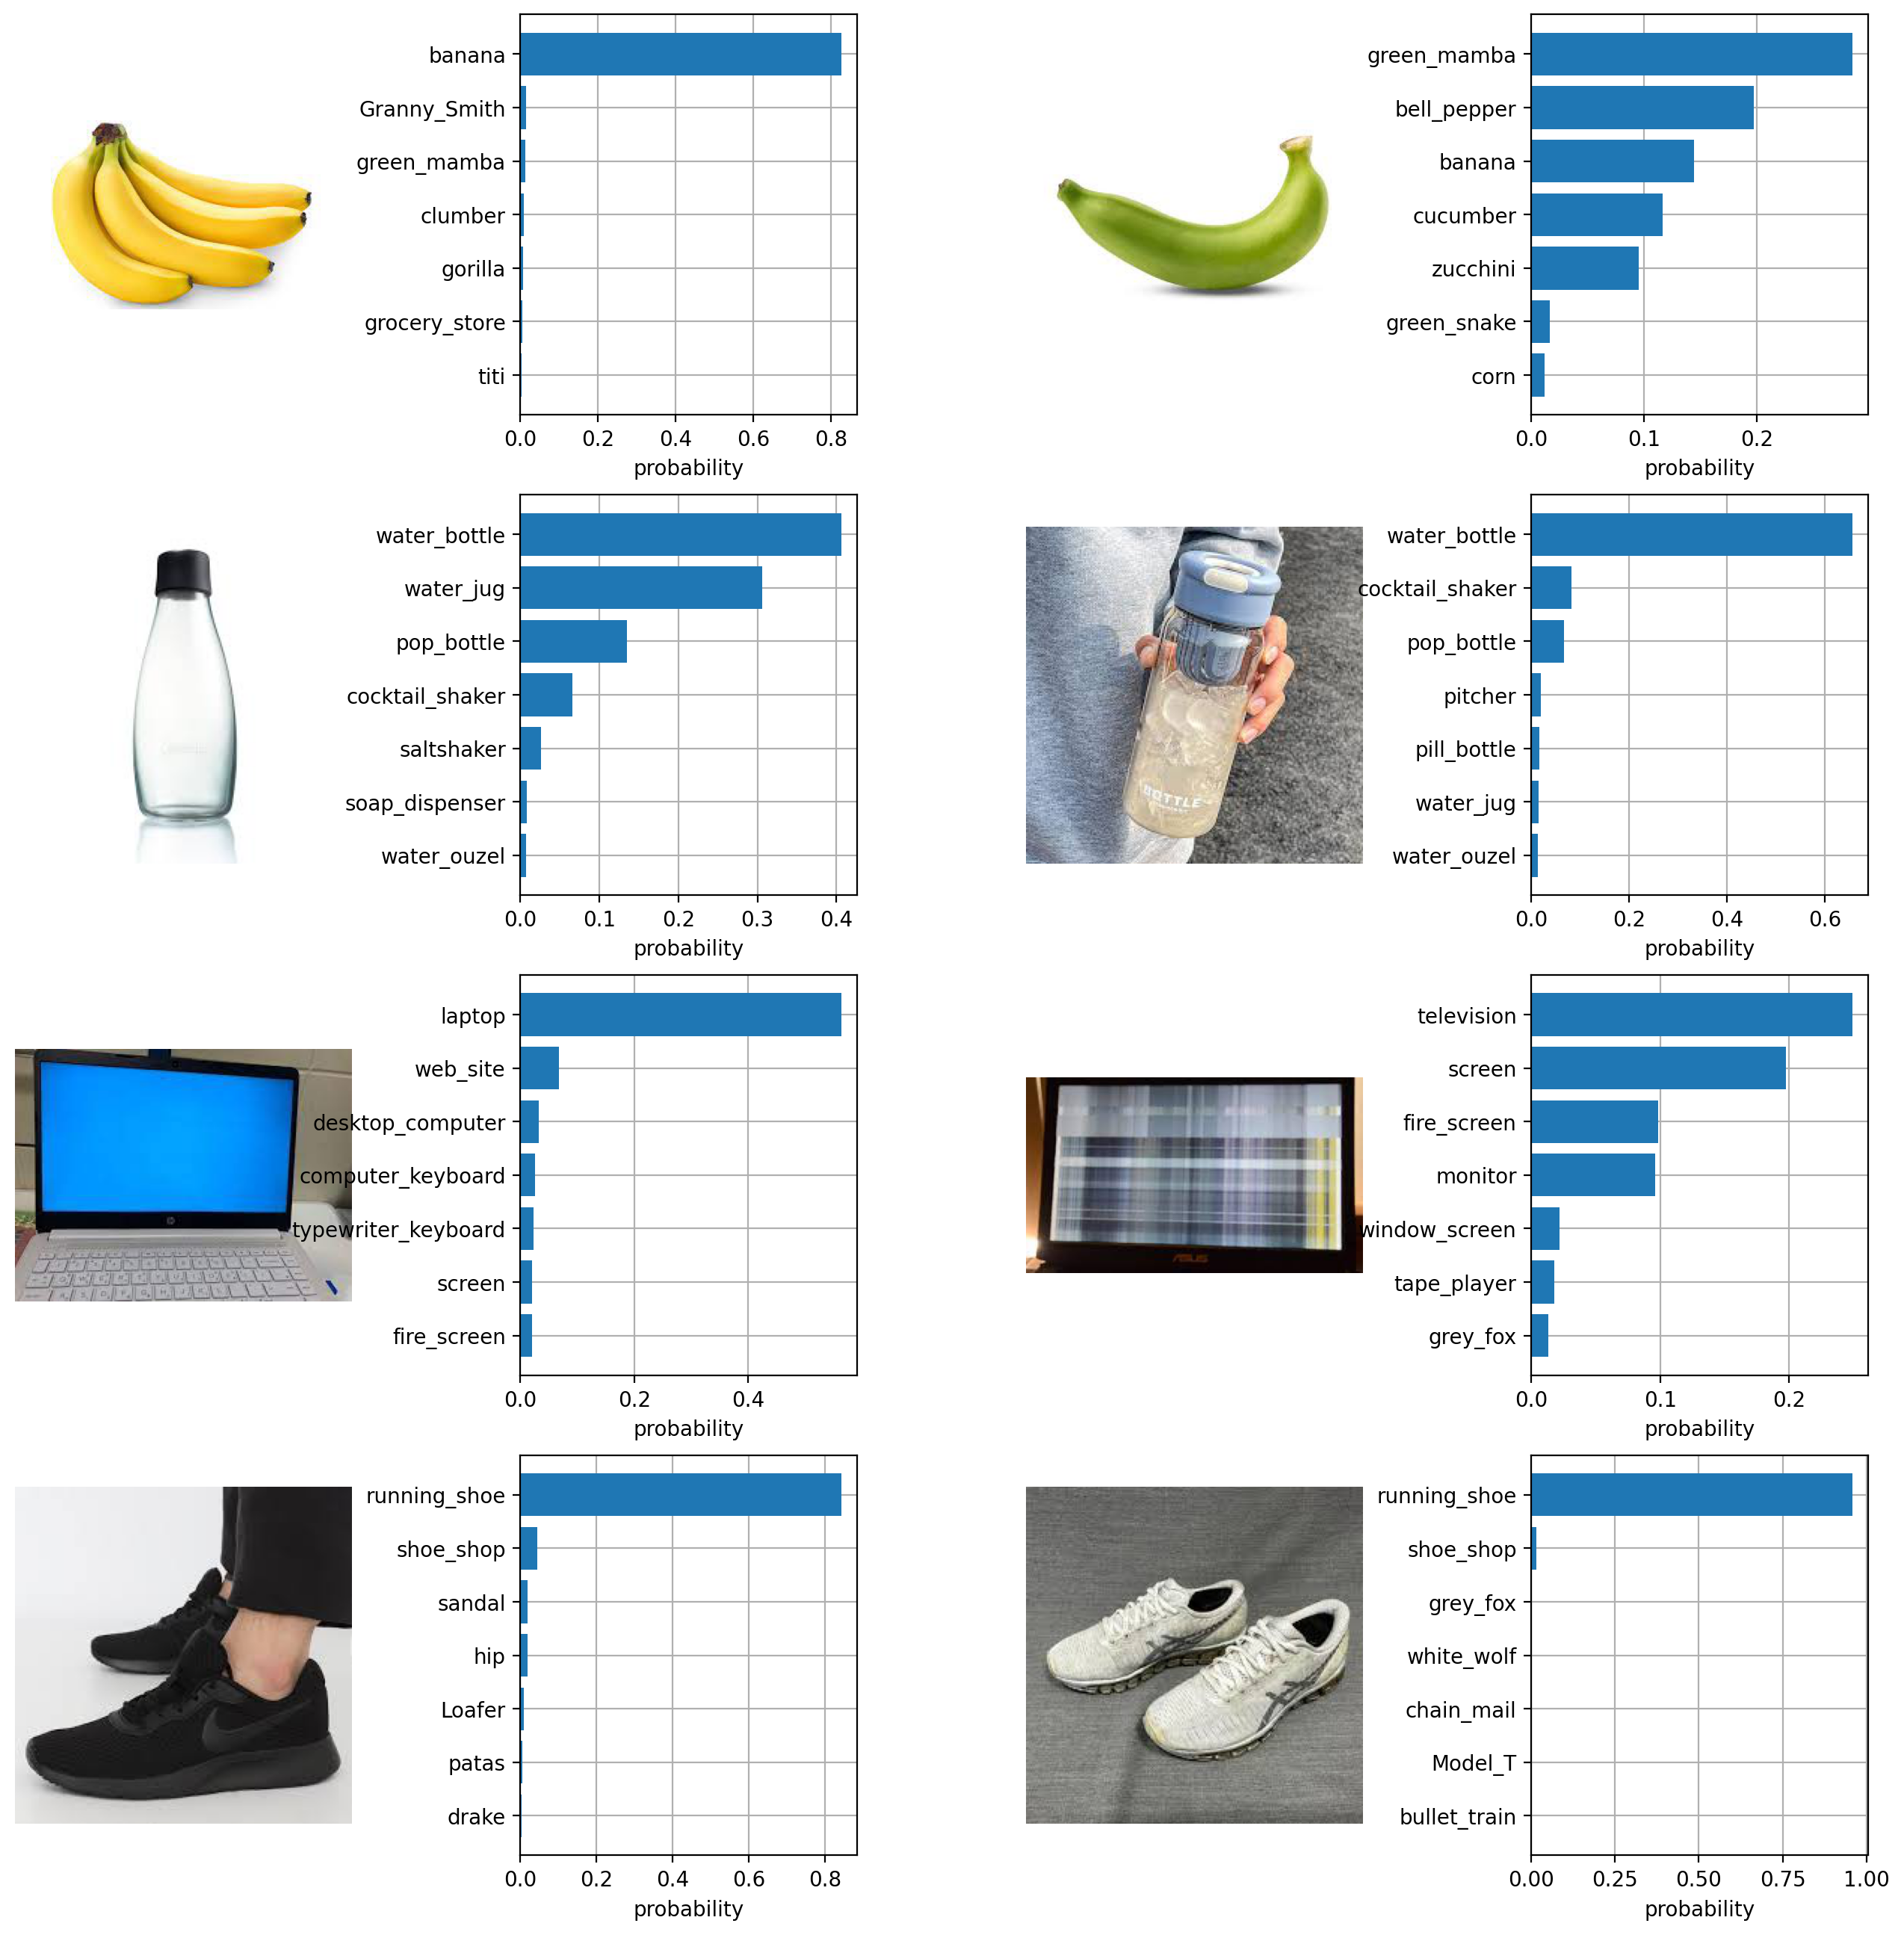

In [15]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [imagenet_labels[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()